In [20]:
# Import modules and packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import json
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import unidecode
import unicodedata
%matplotlib inline

In [4]:
sns.set_style("whitegrid")


In [2]:
# Read in compiled NBA player data
df_orig = pd.read_csv('CompleteNBAPlayerStats.csv')
print("Table of BBall Player Stats:\n\n", df_orig)

Table of BBall Player Stats:

                  name pos team  year    GP    GS  height  weight   college  \
0        Andre Miller  PG  TOT  2016  39.0   4.0    74.0   200.0      Utah   
1       Dirk Nowitzki  PF  DAL  2016  75.0  75.0    83.0   237.0      None   
2       Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0      None   
3       Dirk Nowitzki   C  DAL  2018  77.0  77.0    83.0   237.0      None   
4       Dirk Nowitzki  PF  DAL  2019  51.0  20.0    83.0   237.0      None   
...               ...  ..  ...   ...   ...   ...     ...     ...       ...   
1742    Rui Hachimura  PF  WAS  2020  25.0  25.0    80.0   230.0   Gonzaga   
1743  Sekou Doumbouya  SF  DET  2020  14.0   7.0    80.0   230.0      None   
1744    Terence Davis  SG  TOR  2020  39.0   1.0    76.0   201.0      None   
1745        Ty Jerome  PG  PHX  2020  10.0   0.0    77.0   195.0  Virginia   
1746      Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0  Kentucky   

      country  ...  OFF_SCORE_FR

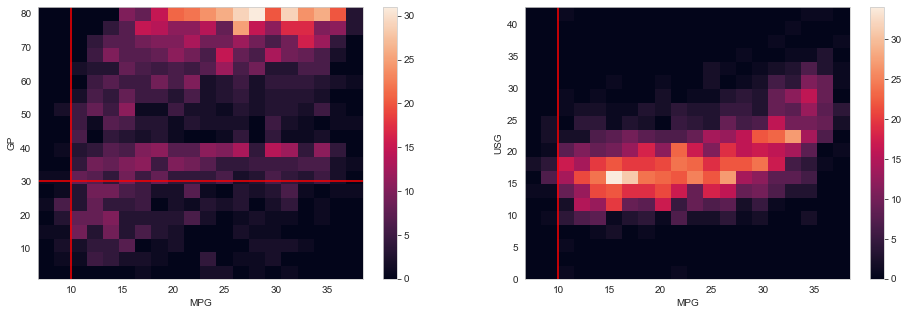

In [5]:
# Establish a minimum number of games played and minutes per game (MPG)
min_num_games = 30
min_MPG = 10

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

#fig = plt.figure()
#jp = sns.jointplot(x="MPG", y="GP", data=df, kind="kde")
#jp.ax_joint.axhline(min_num_games)
#jp.ax_joint.axvline(min_MPG)
plt.axes(ax[0])
plt.xlabel("MPG")
plt.ylabel("GP")
plt.hist2d(df_orig.MPG, df_orig.GP, bins=20)
plt.colorbar()
plt.axhline(min_num_games, c='r')
plt.axvline(min_MPG, c='r')

#fig = plt.figure()
#jp2 = sns.jointplot(x="MPG", y="USG", data=df, kind="kde")
#jp2.ax_joint.axvline(min_MPG)
plt.axes(ax[1])
plt.xlabel("MPG")
plt.ylabel("USG")
plt.hist2d(df_orig.MPG, df_orig.USG, bins=20)
plt.colorbar()
plt.axvline(min_MPG, c='r')


In [7]:
# Dataframes after cutting on GP/MPG/other parameters
df = df_orig.copy()
df = df[df.GP > min_num_games]
df = df[df.MPG > min_MPG]


In [8]:
# Various dataframes separating rookies from established veterans,
# as well as median data to exclude outliers for veteran players
df_vets = df[df["name"].isin(df["name"].value_counts()[df["name"].value_counts()>1].index)]
df_rooks = df[df["name"].isin(df["name"].value_counts()[df["name"].value_counts()==1].index)]
df_med = df_vets.groupby("name").median().reset_index()

# Dataframes by player position
dfc = df[df['pos'].str.contains('C')]
dff = df[df['pos'].str.contains('F')]
dfg = df[df['pos'].str.contains('G')]

# Useful variables for manipulating play-type data
play_types = ['TR', 'ISO', 'PRBH', 'PRRM', 'PU', 'SU', 'HO', 'CUT', 'OS', 'PB', 'MISC']
play_names = ['Transition', 'Isolation', 'PRBH', 'PRRM', 'Post Up', 'Spot Up', 'Hand Off', 'Cut', 'Off Screen', 'Put Back', 'Misc']

def_play_types = ['ISO', 'PRBH', 'PRRM', 'PU', 'SU', 'HO', 'OS']
def_play_names = ['Isolation', 'PRBH', 'PRRM', 'Post Up', 'Spot Up', 'Hand Off', 'Off Screen']


In [ ]:
# Offensive and defensive individual player stats (of relevance for evaluation)
#age,GP,GS,MPG,WLR,
###
#PTS_PT,FGM_PT,FGA_PT,FGP_PT,3PM_PT,3PA_PT,3PP_PT,FTM_PT,FTA_PT,FTP_PT,
#ORB_PT,DRB_PT,TRB_PT,AST_PT,TOV_PT,STL_PT,BLK_PT,PF_PT,PM_PT,
#PTS_OFF_TOV_PT,SEC_CHANCE_PTS_PT,FB_PTS_PT,PTS_PAINT_PT,BLK_ATTEMPT_PT,PF_DRAWN_PT,
#OPP_PTS_TOV_PT,OPP_PTS_2ND_PT,OPP_PTS_FB_PT,OPP_PTS_PAINT_PT,
###
#PTS_PH,FGM_PH,FGA_PH,FGP_PH,3PM_PH,3PA_PH,3PP_PH,FTM_PH,FTA_PH,FTP_PH,
#ORB_PH,DRB_PH,TRB_PH,AST_PH,TOV_PH,STL_PH,BLK_PH,PF_PH,PM_PH,
#PTS_OFF_TOV_PH,SEC_CHANCE_PTS_PH,FB_PTS_PH,PTS_PAINT_PH,BLK_ATTEMPT_PH,PF_DRAWN_PH,
#OPP_PTS_TOV_PH,OPP_PTS_2ND_PH,OPP_PTS_FB_PH,OPP_PTS_PAINT_PH,
#
#PERC_FGM,PERC_FGA,PERC_3PM,PERC_3PA,PERC_FTM,PERC_FTA,PERC_ORB,PERC_DRB,PERC_TRB,PERC_AST,PERC_TOV,PERC_STL,PERC_BLK,PERC_PTS,
#SCREEN_AST_PT,SCREEN_AST_PTS_PT,DEFL_PT,OFF_LB_RECOV_PT,DEF_LB_RECOV_PT,LB_RECOV_PT,PERC_OFF_LB_RECOV_PT,PERC_DEF_LB_RECOV_PT,CHARGE_DRAWN_PT,CONTESTS_2PT_PT,CONTESTS_3PT_PT,CONTESTS_PT,
#DIST_FEET_PG,DIST_M_PG,DIST_M_OFF,DIST_M_DEF,AVG_SPEED,AVG_SPEED_OFF,AVG_SPEED_DEF,
#
#FTR,EFGP,TS,ASTR,TOR,USG,ORR,DRR,REBR,PACE,PIE,OFFRTG,DEFRTG,NETRTG,OWS,DWS,WS,WS48,OBPM,DBPM,BPM,VORP,PER,VA,EWA
#ATR,2PM_PH,2PA_PH,2PP_PH,2PM_PT,2PA_PT,2PP_PT,2PR,3PR,ODRR,AVG_OPP_FGP,WAVG_OPP_FGP
#
#OFF_POSS_ISO,OFF_FREQ_ISO,OFF_PPP_ISO,OFF_FGP_ISO,OFF_EFGP_ISO,OFF_FT_FREQ_ISO,OFF_TO_FREQ_ISO,OFF_SF_FREQ_ISO,OFF_AND1_FREQ_ISO,OFF_SCORE_FREQ_ISO
#DEF_POSS_ISO,DEF_FREQ_ISO,DEF_PPP_ISO,DEF_FGP_ISO,DEF_EFGP_ISO,DEF_FT_FREQ_ISO,DEF_TO_FREQ_ISO,DEF_SF_FREQ_ISO,DEF_AND1_FREQ_ISO,DEF_SCORE_FREQ_ISO

(42, -0.5)

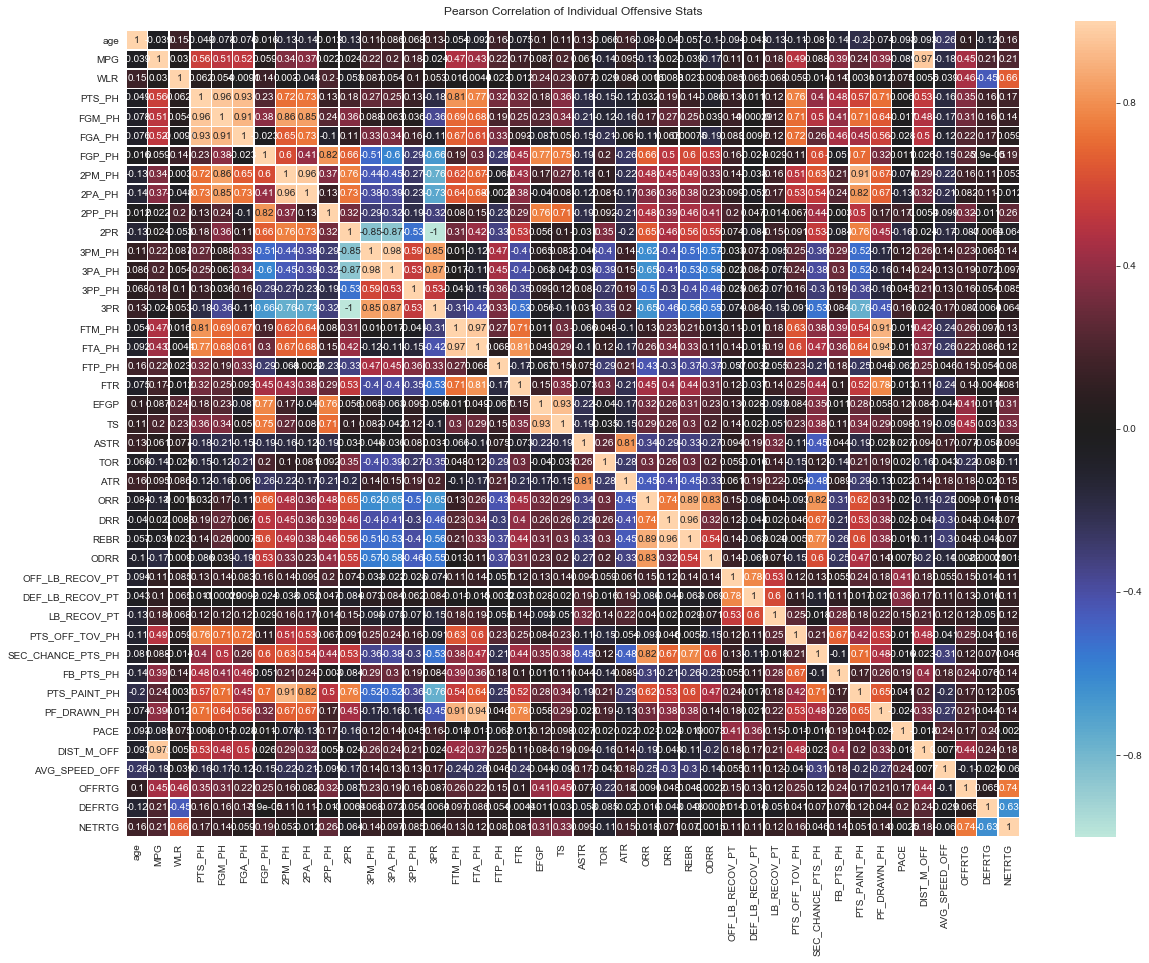

In [9]:
fig3, ax3 = plt.subplots(figsize=(20, 15))
cols_to_inc = ['age','MPG','WLR','PTS_PH','FGM_PH','FGA_PH','FGP_PH','2PM_PH','2PA_PH','2PP_PH','2PR','3PM_PH','3PA_PH','3PP_PH','3PR','FTM_PH','FTA_PH','FTP_PH','FTR','EFGP','TS','ASTR','TOR','ATR','ORR','DRR','REBR','ODRR','OFF_LB_RECOV_PT','DEF_LB_RECOV_PT','LB_RECOV_PT','PTS_OFF_TOV_PH','SEC_CHANCE_PTS_PH','FB_PTS_PH','PTS_PAINT_PH','PF_DRAWN_PH','PACE','DIST_M_OFF','AVG_SPEED_OFF','OFFRTG','DEFRTG','NETRTG']
features = df[cols_to_inc]
pc = features.corr(method='pearson')
sns.heatmap(pc, annot=True, xticklabels=pc.columns, 
            yticklabels=pc.columns, ax=ax3, linewidths=.5, 
            vmin = -1, vmax=1, center=0)
plt.title("Pearson Correlation of Individual Offensive Stats")
ax3.set_ylim(len(pc), -0.5)


(31, -0.5)

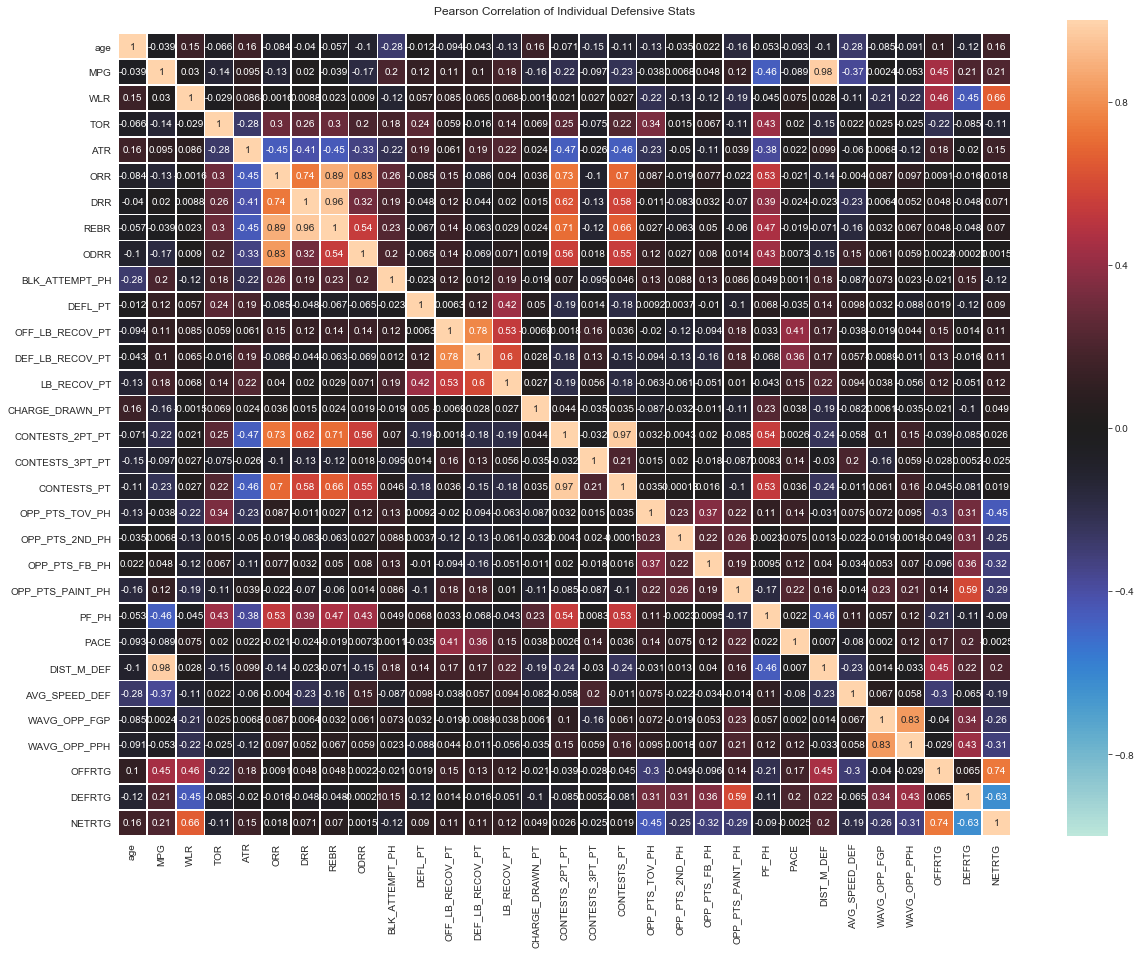

In [10]:
fig3, ax3 = plt.subplots(figsize=(20, 15))
cols_to_inc = ['age','MPG','WLR','TOR','ATR','ORR','DRR','REBR','ODRR','BLK_ATTEMPT_PH','DEFL_PT','OFF_LB_RECOV_PT','DEF_LB_RECOV_PT','LB_RECOV_PT','CHARGE_DRAWN_PT','CONTESTS_2PT_PT','CONTESTS_3PT_PT','CONTESTS_PT','OPP_PTS_TOV_PH','OPP_PTS_2ND_PH','OPP_PTS_FB_PH','OPP_PTS_PAINT_PH','PF_PH','PACE','DIST_M_DEF','AVG_SPEED_DEF','WAVG_OPP_FGP','WAVG_OPP_PPH','OFFRTG','DEFRTG','NETRTG']
features = df[cols_to_inc]
pc = features.corr(method='pearson')
sns.heatmap(pc, annot=True, xticklabels=pc.columns, 
            yticklabels=pc.columns, ax=ax3, linewidths=.5, 
            vmin = -1, vmax=1, center=0)
plt.title("Pearson Correlation of Individual Defensive Stats")
ax3.set_ylim(len(pc), -0.5)


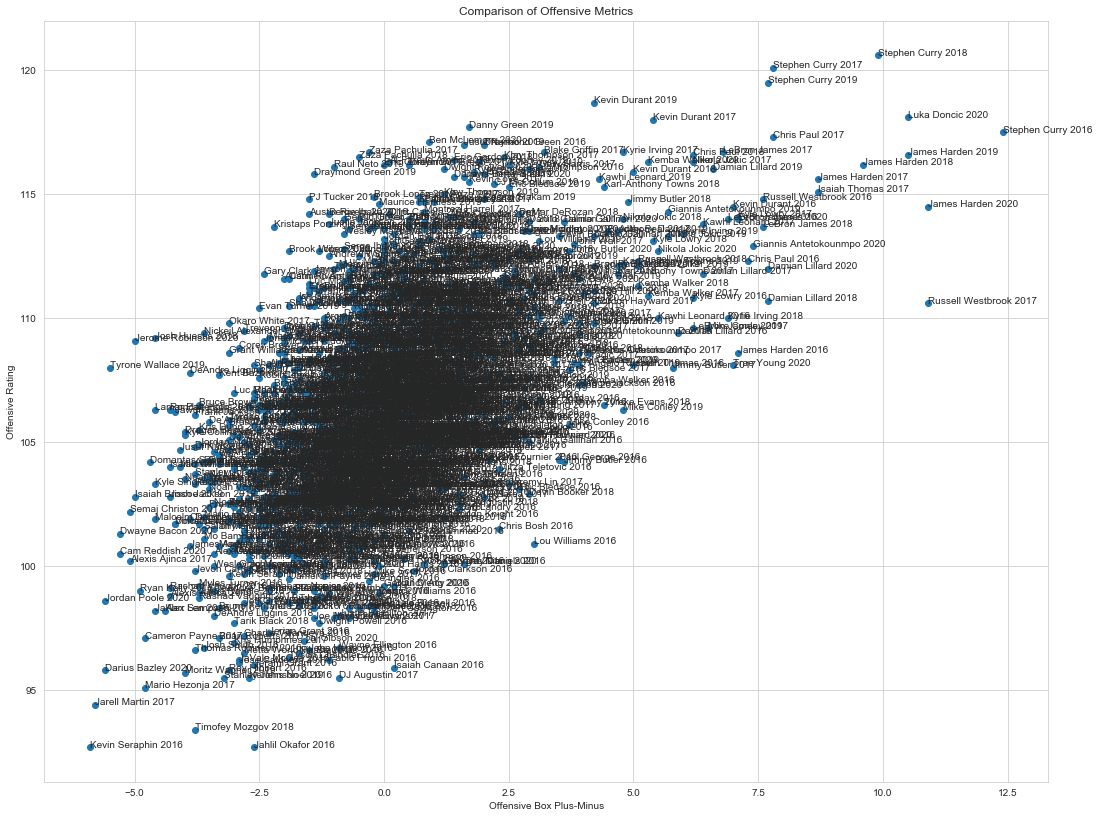

In [11]:
fig, ax = plt.subplots(figsize=(18, 14))
plt.scatter(df.OBPM, df.OFFRTG)
plt.title("Comparison of Offensive Metrics")
plt.xlabel("Offensive Box Plus-Minus")
plt.ylabel("Offensive Rating")
for i, txt in enumerate(df.name):
    ax.annotate(txt+' '+str(df.year.values[i]), (df.OBPM.values[i], df.OFFRTG.values[i]))
    

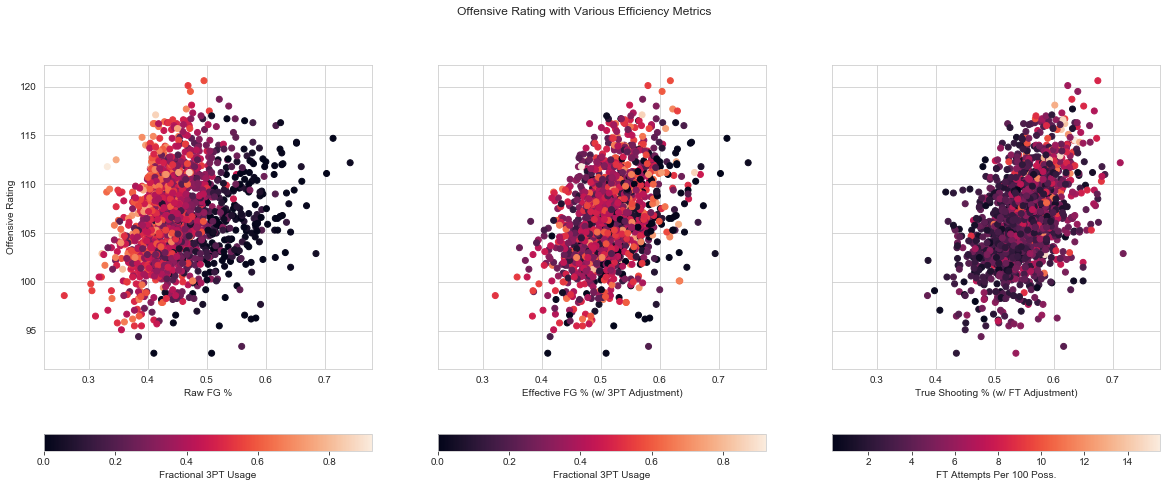

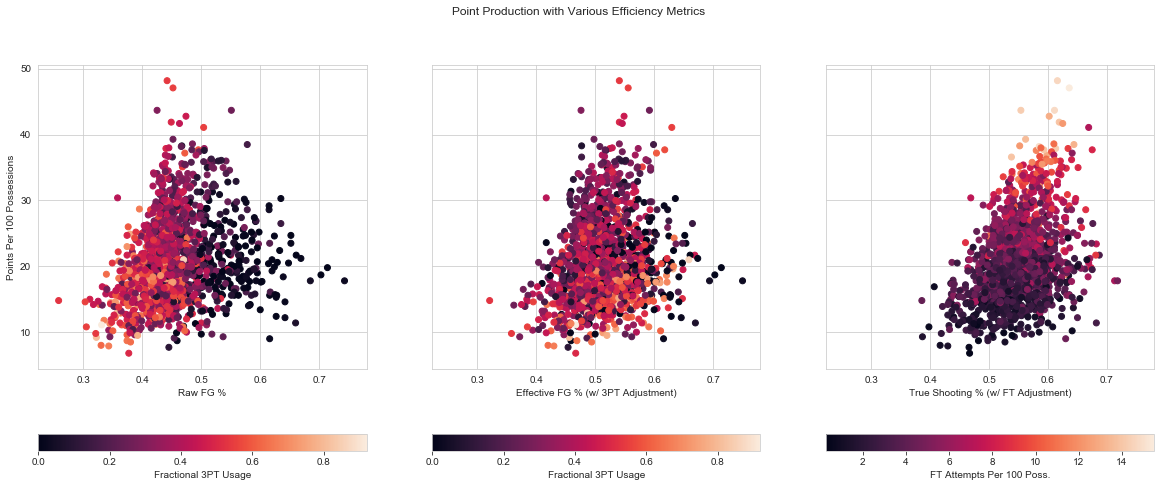

In [132]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharex=True, sharey=True)
plt.suptitle("Offensive Rating with Various Efficiency Metrics")

plt.axes(ax[0])
plt.xlabel("Raw FG %")
plt.ylabel("Offensive Rating")
plt.scatter(df.FGP_PH, df.OFFRTG, c=df['3PR'])
clb = plt.colorbar(orientation='horizontal')
clb.set_label('Fractional 3PT Usage')

plt.axes(ax[1])
plt.xlabel("Effective FG % (w/ 3PT Adjustment)")
plt.scatter(df.EFGP, df.OFFRTG, c=df['3PR'])
clb = plt.colorbar(orientation='horizontal')
clb.set_label('Fractional 3PT Usage')

plt.axes(ax[2])
plt.xlabel("True Shooting % (w/ FT Adjustment)")
plt.scatter(df.TS, df.OFFRTG, c=df['FTA_PH'])
clb = plt.colorbar(orientation='horizontal')
clb.set_label('FT Attempts Per 100 Poss.')


fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharex=True, sharey=True)
plt.suptitle("Point Production with Various Efficiency Metrics")

plt.axes(ax[0])
plt.xlabel("Raw FG %")
plt.ylabel("Points Per 100 Possessions")
plt.scatter(df.FGP_PH, df.PTS_PH, c=df['3PR'])
clb = plt.colorbar(orientation='horizontal')
clb.set_label('Fractional 3PT Usage')

plt.axes(ax[1])
plt.xlabel("Effective FG % (w/ 3PT Adjustment)")
plt.scatter(df.EFGP, df.PTS_PH, c=df['3PR'])
clb = plt.colorbar(orientation='horizontal')
clb.set_label('Fractional 3PT Usage')

plt.axes(ax[2])
plt.xlabel("True Shooting % (w/ FT Adjustment)")
plt.scatter(df.TS, df.PTS_PH, c=df['FTA_PH'])
clb = plt.colorbar(orientation='horizontal')
clb.set_label('FT Attempts Per 100 Poss.')

#cax,kw = mpl.colorbar.make_axes([x for x in ax.flat])
#plt.colorbar(fig, cax=cax, **kw)


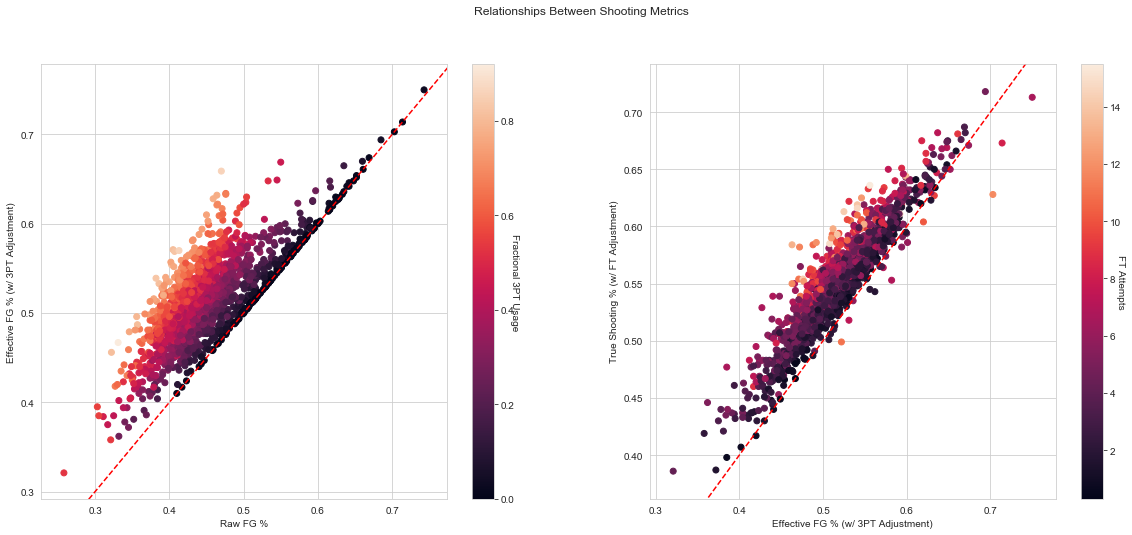

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plt.suptitle("Relationships Between Shooting Metrics")

plt.axes(ax[0])
plt.xlabel("Raw FG %")
plt.ylabel("Effective FG % (w/ 3PT Adjustment)")
plt.scatter(df.FGP_PH, df.EFGP, c=df["3PR"])
xmin, xmax = ax[0].get_xlim()
ymin, ymax = ax[0].get_ylim()
plt.plot([0,1], [0,1], 'r--')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
clb = plt.colorbar()
clb.set_label('Fractional 3PT Usage', rotation=270)
#for i, txt in enumerate(df[df.OFFRTG.values>80].name.values):
#    ax.annotate(txt+' '+str(df.year.values[i]), (df.FGP.values[i], df.EFGP.values[i]))

plt.axes(ax[1])
plt.xlabel("Effective FG % (w/ 3PT Adjustment)")
plt.ylabel("True Shooting % (w/ FT Adjustment)")
plt.scatter(df.EFGP, df.TS, c=df.FTA_PH)
xmin, xmax = ax[1].get_xlim()
ymin, ymax = ax[1].get_ylim()
plt.plot([0,1], [0,1], 'r--')
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
clb = plt.colorbar()
clb.set_label('FT Attempts', rotation=270)
#for i, txt in enumerate(df[df.OFFRTG.values>80].name.values):
#    ax.annotate(txt+' '+str(df.year.values[i]), (df.EFGP.values[i]/100., df.TS.values[i]))


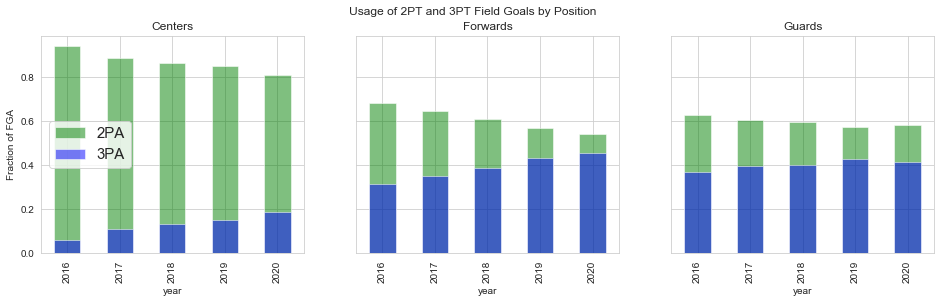

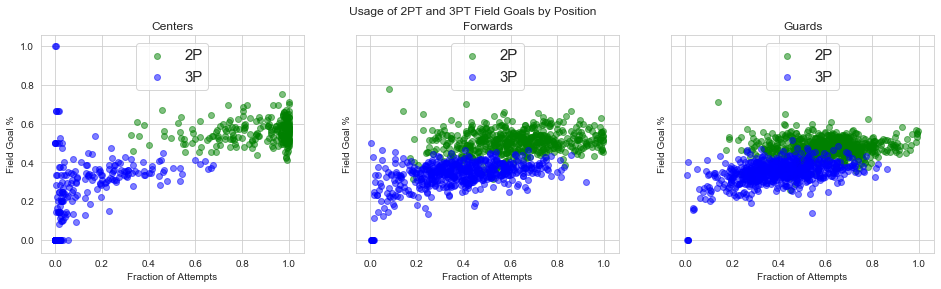

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)
plt.suptitle("Usage of 2PT and 3PT Field Goals by Position")

plt.axes(ax[0])
plt.title("Centers")
plt.ylabel("Fraction of FGA")
dfc.groupby("year")["2PR"].mean().plot.bar(color='g', alpha=0.5, label="2PA")
dfc.groupby("year")["3PR"].mean().plot.bar(color='b', alpha=0.5, label="3PA")
plt.legend(loc="center left", prop={'size': 15})

plt.axes(ax[1])
plt.title("Forwards")
dff.groupby("year")["2PR"].mean().plot.bar(color='g', alpha=0.5)
dff.groupby("year")["3PR"].mean().plot.bar(color='b', alpha=0.5)

plt.axes(ax[2])
plt.title("Guards")
dfg.groupby("year")["2PR"].mean().plot.bar(color='g', alpha=0.5)
dfg.groupby("year")["3PR"].mean().plot.bar(color='b', alpha=0.5)
#plt.bar(dfc.groupby("year")["2PR"].mean().reset_index().year.values, dfc.groupby("year")["2PR"].mean().values, color='r')


fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)
plt.suptitle("Usage of 2PT and 3PT Field Goals by Position")
plt.axes(ax[0])
plt.title("Centers")
plt.xlabel("Fraction of Attempts")
plt.ylabel("Field Goal %")
plt.scatter(dfc["2PR"], dfc["2PP_PH"], color='g', alpha=0.5, label="2P")
plt.scatter(dfc["3PR"], dfc["3PP_PH"], color='b', alpha=0.5, label="3P")
plt.legend(loc="upper center", prop={'size': 15})
#plt.ylim(0, 1)

plt.axes(ax[1])
plt.title("Forwards")
plt.xlabel("Fraction of Attempts")
plt.ylabel("Field Goal %")
plt.scatter(dff["2PR"], dff["2PP_PH"], color='g', alpha=0.5, label="2P")
plt.scatter(dff["3PR"], dff["3PP_PH"], color='b', alpha=0.5, label="3P")
plt.legend(loc="upper center", prop={'size': 15})
#plt.ylim(0, 1)

plt.axes(ax[2])
plt.title("Guards")
plt.xlabel("Fraction of Attempts")
plt.ylabel("Field Goal %")
plt.scatter(dfg["2PR"], dfg["2PP_PH"], color='g', alpha=0.5, label="2P")
plt.scatter(dfg["3PR"], dfg["3PP_PH"], color='b', alpha=0.5, label="3P")
plt.legend(loc="upper center", prop={'size': 15})
#plt.ylim(0, 1)


In [133]:
#fig, ax = plt.subplots(figsize=(10, 7))
#df_steph = df[df.name=="Stephen Curry"]
#plt.title("Evolution of Steph Curry's 3PT Usage")
#plt.xlabel("Ratio of 2PT Attempts")
#plt.ylabel("Ratio of 3PT Attempts")
#plt.scatter(df_steph["2PR"], df_steph["3PR"], c=df_steph["3PP_PH"], cmap='rainbow')
#for i, txt in enumerate(df_steph.name):
#    ax.annotate(txt+' '+str(df_steph.year.values[i]), (df_steph["2PR"].values[i], df_steph["3PR"].values[i]))
#plt.colorbar()
#plt.clim(0.35, 0.48)
#plt.xlim(0.38, 0.48)
#plt.ylim(0.53, 0.63)


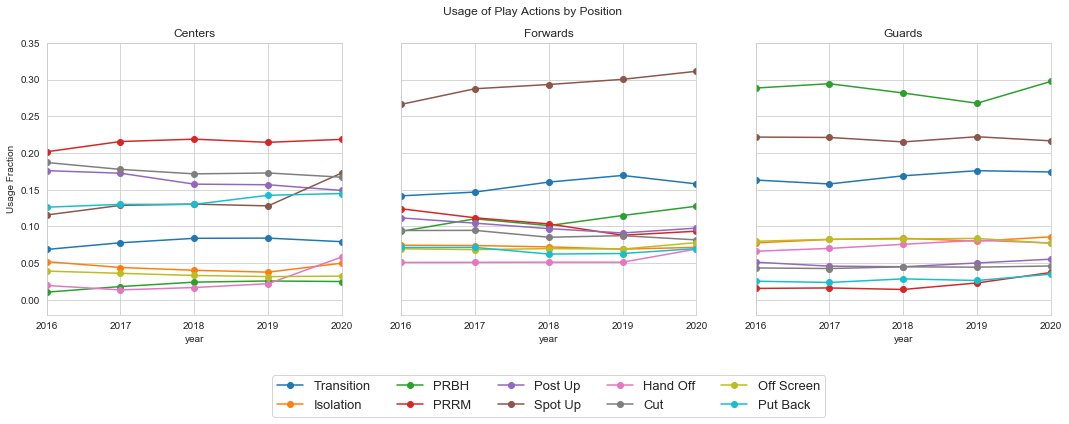

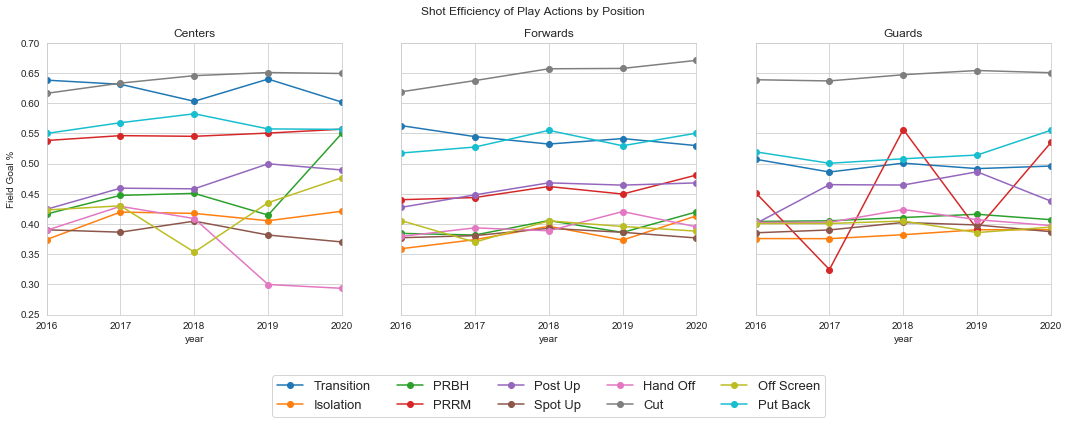

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
plt.suptitle("Usage of Play Actions by Position")

plt.axes(ax[0])
plt.title("Centers")
plt.ylabel("Usage Fraction")
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        dfc[dfc["OFF_FREQ_"+pt]>0].groupby("year")["OFF_FREQ_"+pt].mean().plot(marker="o", label=play_names[i])
plt.ylim(-0.02, 0.35)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))

plt.axes(ax[1])
plt.title("Forwards")
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        dff[dff["OFF_FREQ_"+pt]>0].groupby("year")["OFF_FREQ_"+pt].mean().plot(marker="o", label=play_names[i])
ax[1].xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.4), prop={'size': 13})
        
plt.axes(ax[2])
plt.title("Guards")
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        dfg[dfg["OFF_FREQ_"+pt]>0].groupby("year")["OFF_FREQ_"+pt].mean().plot(marker="o", label=play_names[i])
ax[2].xaxis.set_major_locator(plt.MultipleLocator(1))


fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
plt.suptitle("Shot Efficiency of Play Actions by Position")

plt.axes(ax[0])
plt.title("Centers")
plt.ylabel("Field Goal %")
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        dfc[dfc["OFF_FREQ_"+pt]>0].groupby("year")["OFF_FGP_"+pt].mean().plot(marker="o", label=play_names[i])
#plt.legend(loc="center left")
plt.ylim(0.25, 0.7)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))

plt.axes(ax[1])
plt.title("Forwards")
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        dff[dff["OFF_FREQ_"+pt]>0].groupby("year")["OFF_FGP_"+pt].mean().plot(marker="o", label=play_names[i])
ax[1].xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.4), prop={'size': 13})

plt.axes(ax[2])
plt.title("Guards")
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        dfg[dfg["OFF_FREQ_"+pt]>0].groupby("year")["OFF_FGP_"+pt].mean().plot(marker="o", label=play_names[i])
ax[2].xaxis.set_major_locator(plt.MultipleLocator(1))


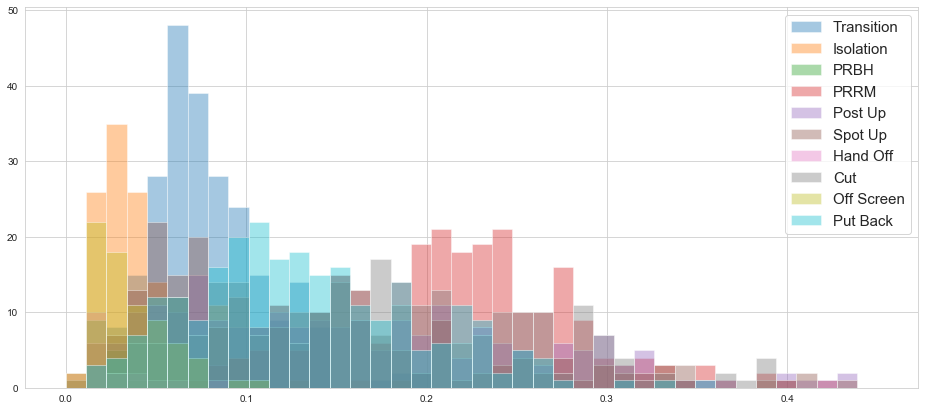

In [93]:
fig, ax = plt.subplots(figsize=(16, 7))
#plt.yscale("log")
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        plt.hist(dfc[dfc['OFF_FREQ_'+pt]>0.01]['OFF_FREQ_'+pt], bins=40, alpha=0.4, label=play_names[i], range=(0,0.45))
plt.legend(prop={'size': 15})


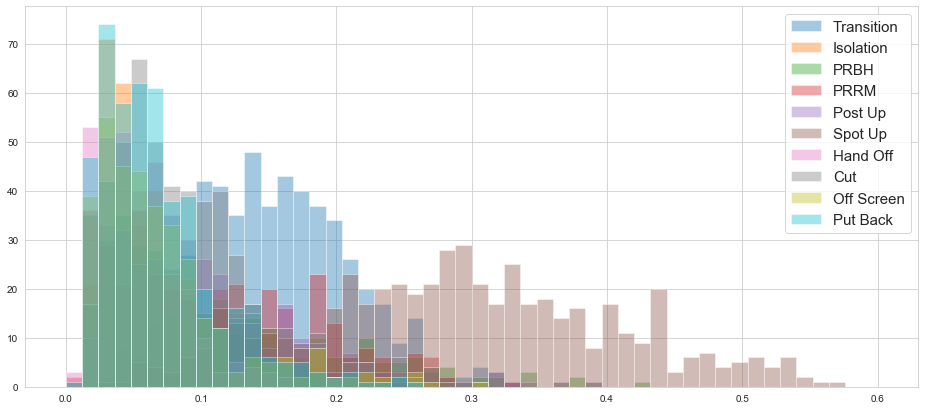

In [100]:
fig, ax = plt.subplots(figsize=(16, 7))
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        plt.hist(dff[dff['OFF_FREQ_'+pt]>0.01]['OFF_FREQ_'+pt], bins=50, alpha=0.4, label=play_names[i], range=(0,0.6))
plt.legend(prop={'size': 15})


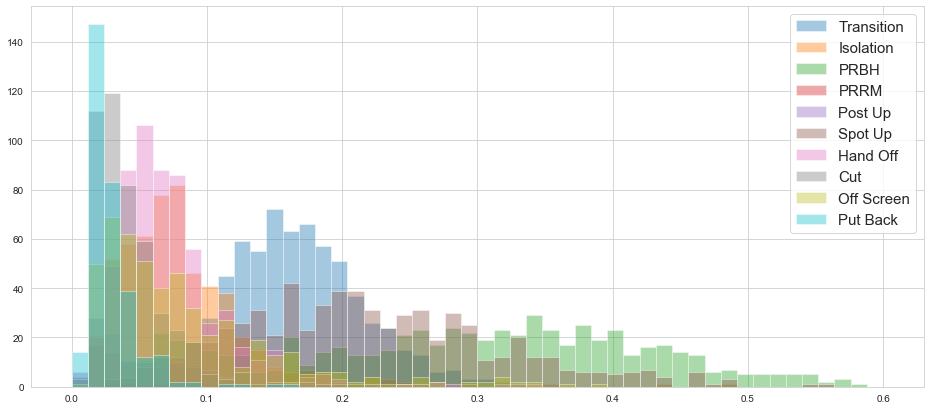

In [102]:
fig, ax = plt.subplots(figsize=(16, 7))
for i,pt in enumerate(play_types):
    if pt != 'MISC':
        plt.hist(dfg[dfg['OFF_FREQ_'+pt]>0.01]['OFF_FREQ_'+pt], bins=50, alpha=0.4, label=play_names[i], range=(0,0.6))
plt.legend(prop={'size': 15})


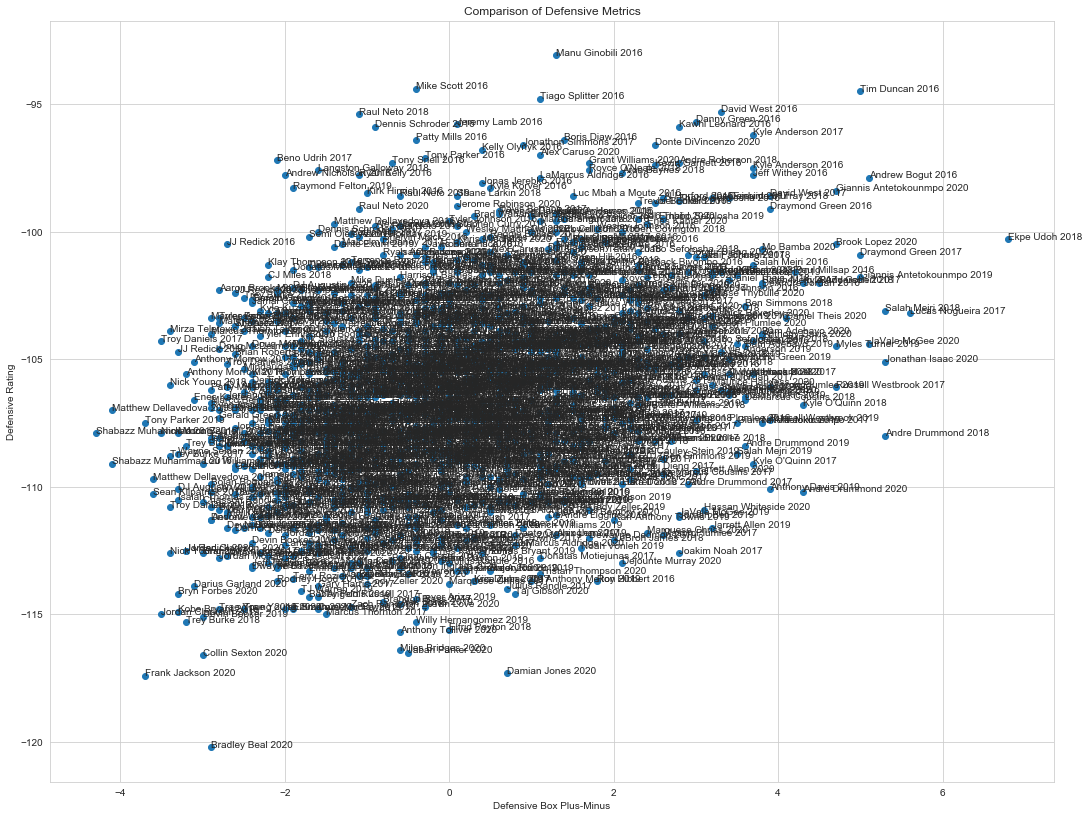

In [103]:
fig, ax = plt.subplots(figsize=(18, 14))
plt.scatter(df.DBPM, -df.DEFRTG)
plt.title("Comparison of Defensive Metrics")
plt.xlabel("Defensive Box Plus-Minus")
plt.ylabel("Defensive Rating")
for i, txt in enumerate(df.name):
    ax.annotate(txt+' '+str(df.year.values[i]), (df.DBPM.values[i], -df.DEFRTG.values[i]))


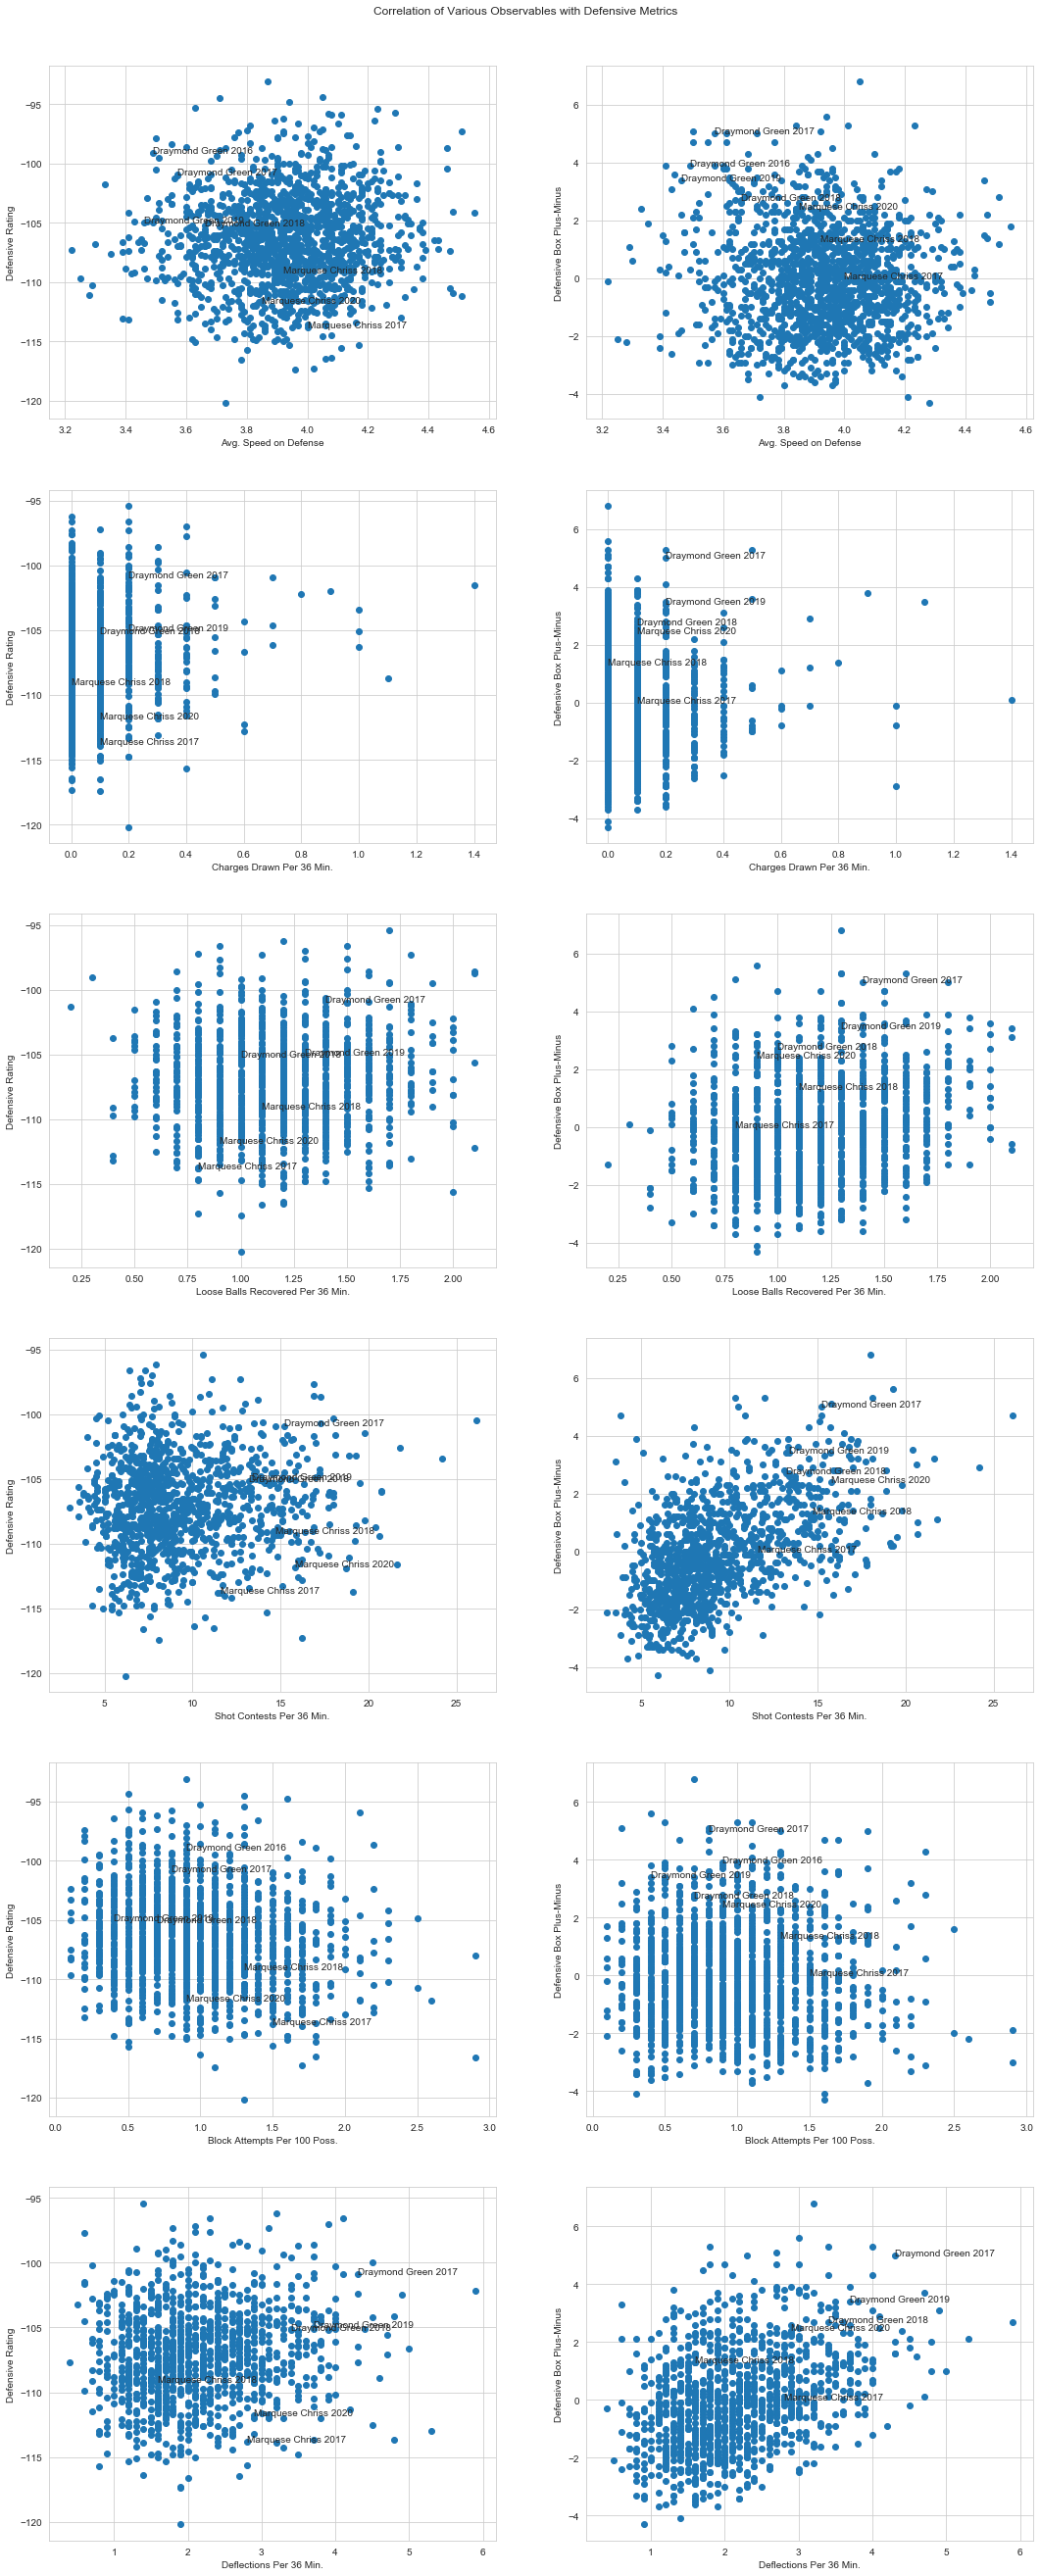

In [127]:
fig, ax = plt.subplots(6, 2, figsize=(18, 42))
plt.suptitle("Correlation of Various Observables with Defensive Metrics")
fig.subplots_adjust(top=0.96)


# Interestingly, very little correlation with speed on defense and defensive rating.
# If anything, well-known good defenders are slower and more deliberate...
plt.axes(ax[0,0])
plt.xlabel("Avg. Speed on Defense")
plt.ylabel("Defensive Rating")
plt.scatter(df.AVG_SPEED_DEF, -df.DEFRTG)
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[0,0].annotate(txt+' '+str(df.year.values[i]), (df.AVG_SPEED_DEF.values[i], -df.DEFRTG.values[i]))

plt.axes(ax[0,1])
plt.scatter(df.AVG_SPEED_DEF, df.DBPM)
plt.xlabel("Avg. Speed on Defense")
plt.ylabel("Defensive Box Plus-Minus")
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[0,1].annotate(txt+' '+str(df.year.values[i]), (df.AVG_SPEED_DEF.values[i], df.DBPM.values[i]))


# Very wide scatter, little correlation with charges drawn...
# Have to be VERY exceptional at this for it to have great impact.
# Great defenders can draw a charge, but isn't the crux of great defense.
plt.axes(ax[1,0])
plt.xlabel("Charges Drawn Per 36 Min.")
plt.ylabel("Defensive Rating")
plt.scatter(df.CHARGE_DRAWN_PT, -df.DEFRTG)
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[1,0].annotate(txt+' '+str(df.year.values[i]), (df.CHARGE_DRAWN_PT.values[i], -df.DEFRTG.values[i]))

plt.axes(ax[1,1])
plt.scatter(df.CHARGE_DRAWN_PT, df.DBPM)
plt.xlabel("Charges Drawn Per 36 Min.")
plt.ylabel("Defensive Box Plus-Minus")
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[1,1].annotate(txt+' '+str(df.year.values[i]), (df.CHARGE_DRAWN_PT.values[i], df.DBPM.values[i]))


# Loose balls recovered appears to have almost no correlation
# with defensive rating, very flat distribution.
# Most "hustle" players are middle-of-the-pack defensively.
# Maybe there is a correlation with being a guard, or smaller player...?
plt.axes(ax[2,0])
plt.xlabel("Loose Balls Recovered Per 36 Min.")
plt.ylabel("Defensive Rating")
plt.scatter(df.LB_RECOV_PT, -df.DEFRTG)
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[2,0].annotate(txt+' '+str(df.year.values[i]), (df.LB_RECOV_PT.values[i], -df.DEFRTG.values[i]))

plt.axes(ax[2,1])
plt.scatter(df.LB_RECOV_PT, df.DBPM)
plt.xlabel("Loose Balls Recovered Per 36 Min.")
plt.ylabel("Defensive Box Plus-Minus")
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[2,1].annotate(txt+' '+str(df.year.values[i]), (df.LB_RECOV_PT.values[i], df.DBPM.values[i]))


# Very little correlation actually. "Arrowhead" shape to distribution.
# Great defenders tend to contest, but on average the most frequent contesters 
# have middle-of-the-pack defensive rating.
plt.axes(ax[3,0])
plt.xlabel("Shot Contests Per 36 Min.")
plt.ylabel("Defensive Rating")
plt.scatter(df.CONTESTS_PT, -df.DEFRTG)
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[3,0].annotate(txt+' '+str(df.year.values[i]), (df.CONTESTS_PT.values[i], -df.DEFRTG.values[i]))

plt.axes(ax[3,1])
plt.scatter(df.CONTESTS_PT, df.DBPM)
plt.xlabel("Shot Contests Per 36 Min.")
plt.ylabel("Defensive Box Plus-Minus")
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[3,1].annotate(txt+' '+str(df.year.values[i]), (df.CONTESTS_PT.values[i], df.DBPM.values[i]))

        
plt.axes(ax[4,0])
plt.xlabel("Block Attempts Per 100 Poss.")
plt.ylabel("Defensive Rating")
plt.scatter(df.BLK_ATTEMPT_PH, -df.DEFRTG)
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[4,0].annotate(txt+' '+str(df.year.values[i]), (df.BLK_ATTEMPT_PH.values[i], -df.DEFRTG.values[i]))

plt.axes(ax[4,1])
plt.scatter(df.BLK_ATTEMPT_PH, df.DBPM)
plt.xlabel("Block Attempts Per 100 Poss.")
plt.ylabel("Defensive Box Plus-Minus")
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[4,1].annotate(txt+' '+str(df.year.values[i]), (df.BLK_ATTEMPT_PH.values[i], df.DBPM.values[i]))


# A little more correlation between deflections and defensive rating,
# which is sensible since it takes length and savvy to save buckets.
# The best defenders tend to have more deflections.
plt.axes(ax[5,0])
plt.xlabel("Deflections Per 36 Min.")
plt.ylabel("Defensive Rating")
plt.scatter(df.DEFL_PT, -df.DEFRTG)
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[5,0].annotate(txt+' '+str(df.year.values[i]), (df.DEFL_PT.values[i], -df.DEFRTG.values[i]))

plt.axes(ax[5,1])
plt.scatter(df.DEFL_PT, df.DBPM)
plt.xlabel("Deflections Per 36 Min.")
plt.ylabel("Defensive Box Plus-Minus")
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[5,1].annotate(txt+' '+str(df.year.values[i]), (df.DEFL_PT.values[i], df.DBPM.values[i]))



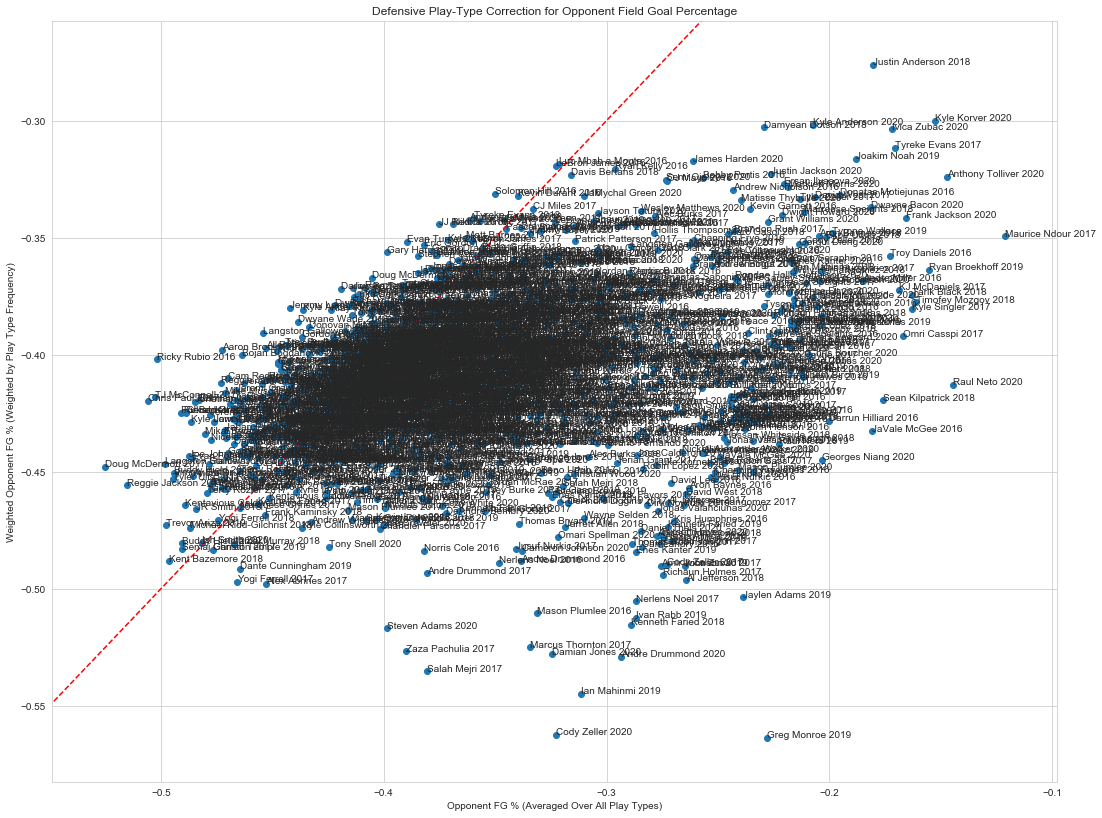

In [105]:
fig, ax = plt.subplots(figsize=(18, 14))
plt.scatter(-df.AVG_OPP_FGP, -df.WAVG_OPP_FGP)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([-1,0], [-1,0], 'r--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.title("Defensive Play-Type Correction for Opponent Field Goal Percentage")
plt.xlabel("Opponent FG % (Averaged Over All Play Types)")
plt.ylabel("Weighted Opponent FG % (Weighted by Play Type Frequency)")
for i, txt in enumerate(df.name):
    ax.annotate(txt+' '+str(df.year.values[i]), (-df.AVG_OPP_FGP.values[i], -df.WAVG_OPP_FGP.values[i]))


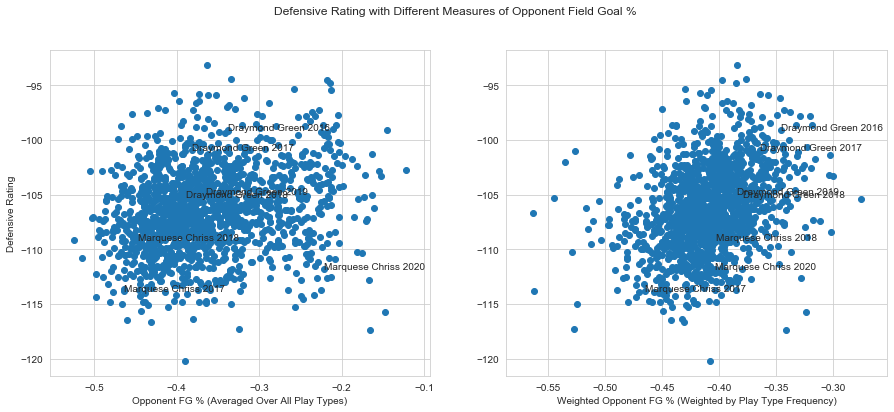

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plt.suptitle("Defensive Rating with Different Measures of Opponent Field Goal %")

plt.axes(ax[0])
plt.xlabel("Opponent FG % (Averaged Over All Play Types)")
plt.ylabel("Defensive Rating")
plt.scatter(-df.AVG_OPP_FGP, -df.DEFRTG)
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[0].annotate(txt+' '+str(df.year.values[i]), (-df.AVG_OPP_FGP.values[i], -df.DEFRTG.values[i]))

plt.axes(ax[1])
plt.xlabel("Weighted Opponent FG % (Weighted by Play Type Frequency)")
plt.scatter(-df.WAVG_OPP_FGP, -df.DEFRTG)
for i, txt in enumerate(df.name):
    if txt == "Marquese Chriss" or txt == "Draymond Green":
        ax[1].annotate(txt+' '+str(df.year.values[i]), (-df.WAVG_OPP_FGP.values[i], -df.DEFRTG.values[i]))


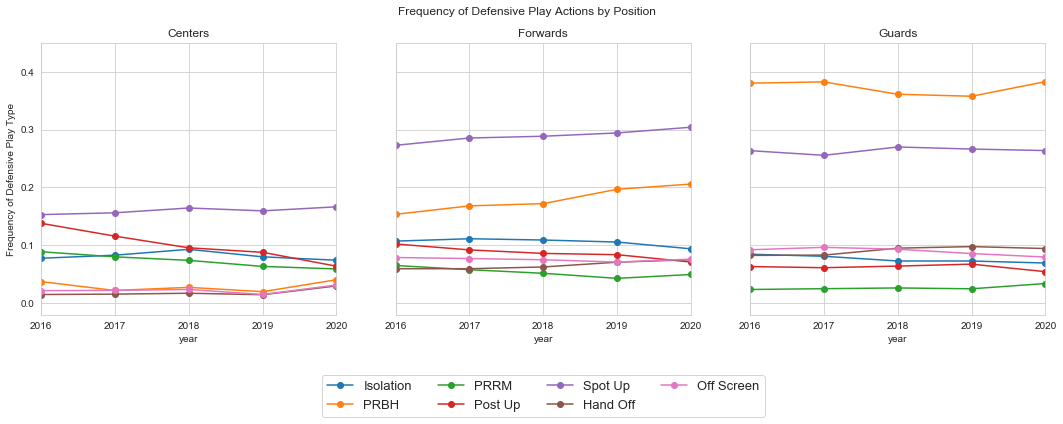

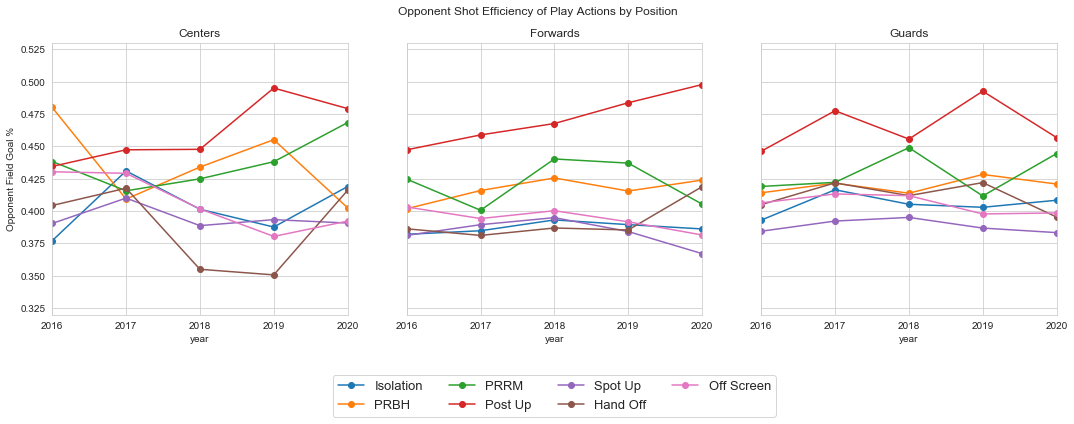

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
plt.suptitle("Frequency of Defensive Play Actions by Position")

plt.axes(ax[0])
plt.title("Centers")
plt.ylabel("Frequency of Defensive Play Type")
for i,pt in enumerate(def_play_types):
    if pt != 'MISC':
        dfc[dfc["DEF_FREQ_"+pt]>0].groupby("year")["DEF_FREQ_"+pt].mean().plot(marker="o", label=def_play_names[i])
plt.ylim(-0.02, 0.45)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))

plt.axes(ax[1])
plt.title("Forwards")
for i,pt in enumerate(def_play_types):
    if pt != 'MISC':
        dff[dff["DEF_FREQ_"+pt]>0].groupby("year")["DEF_FREQ_"+pt].mean().plot(marker="o", label=def_play_names[i])
ax[1].xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.4), prop={'size': 13})
        
plt.axes(ax[2])
plt.title("Guards")
for i,pt in enumerate(def_play_types):
    if pt != 'MISC':
        dfg[dfg["DEF_FREQ_"+pt]>0].groupby("year")["DEF_FREQ_"+pt].mean().plot(marker="o", label=def_play_names[i])
ax[2].xaxis.set_major_locator(plt.MultipleLocator(1))


fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
plt.suptitle("Opponent Shot Efficiency of Play Actions by Position")

plt.axes(ax[0])
plt.title("Centers")
plt.ylabel("Opponent Field Goal %")
for i,pt in enumerate(def_play_types):
    if pt != 'MISC':
        dfc[dfc["DEF_FREQ_"+pt]>0].groupby("year")["DEF_FGP_"+pt].mean().plot(marker="o", label=def_play_names[i])
#plt.legend(loc="center left")
plt.ylim(0.32, 0.53)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))

plt.axes(ax[1])
plt.title("Forwards")
for i,pt in enumerate(def_play_types):
    if pt != 'MISC':
        dff[dff["DEF_FREQ_"+pt]>0].groupby("year")["DEF_FGP_"+pt].mean().plot(marker="o", label=def_play_names[i])
ax[1].xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.4), prop={'size': 13})

plt.axes(ax[2])
plt.title("Guards")
for i,pt in enumerate(def_play_types):
    if pt != 'MISC':
        dfg[dfg["DEF_FREQ_"+pt]>0].groupby("year")["DEF_FGP_"+pt].mean().plot(marker="o", label=def_play_names[i])
ax[2].xaxis.set_major_locator(plt.MultipleLocator(1))


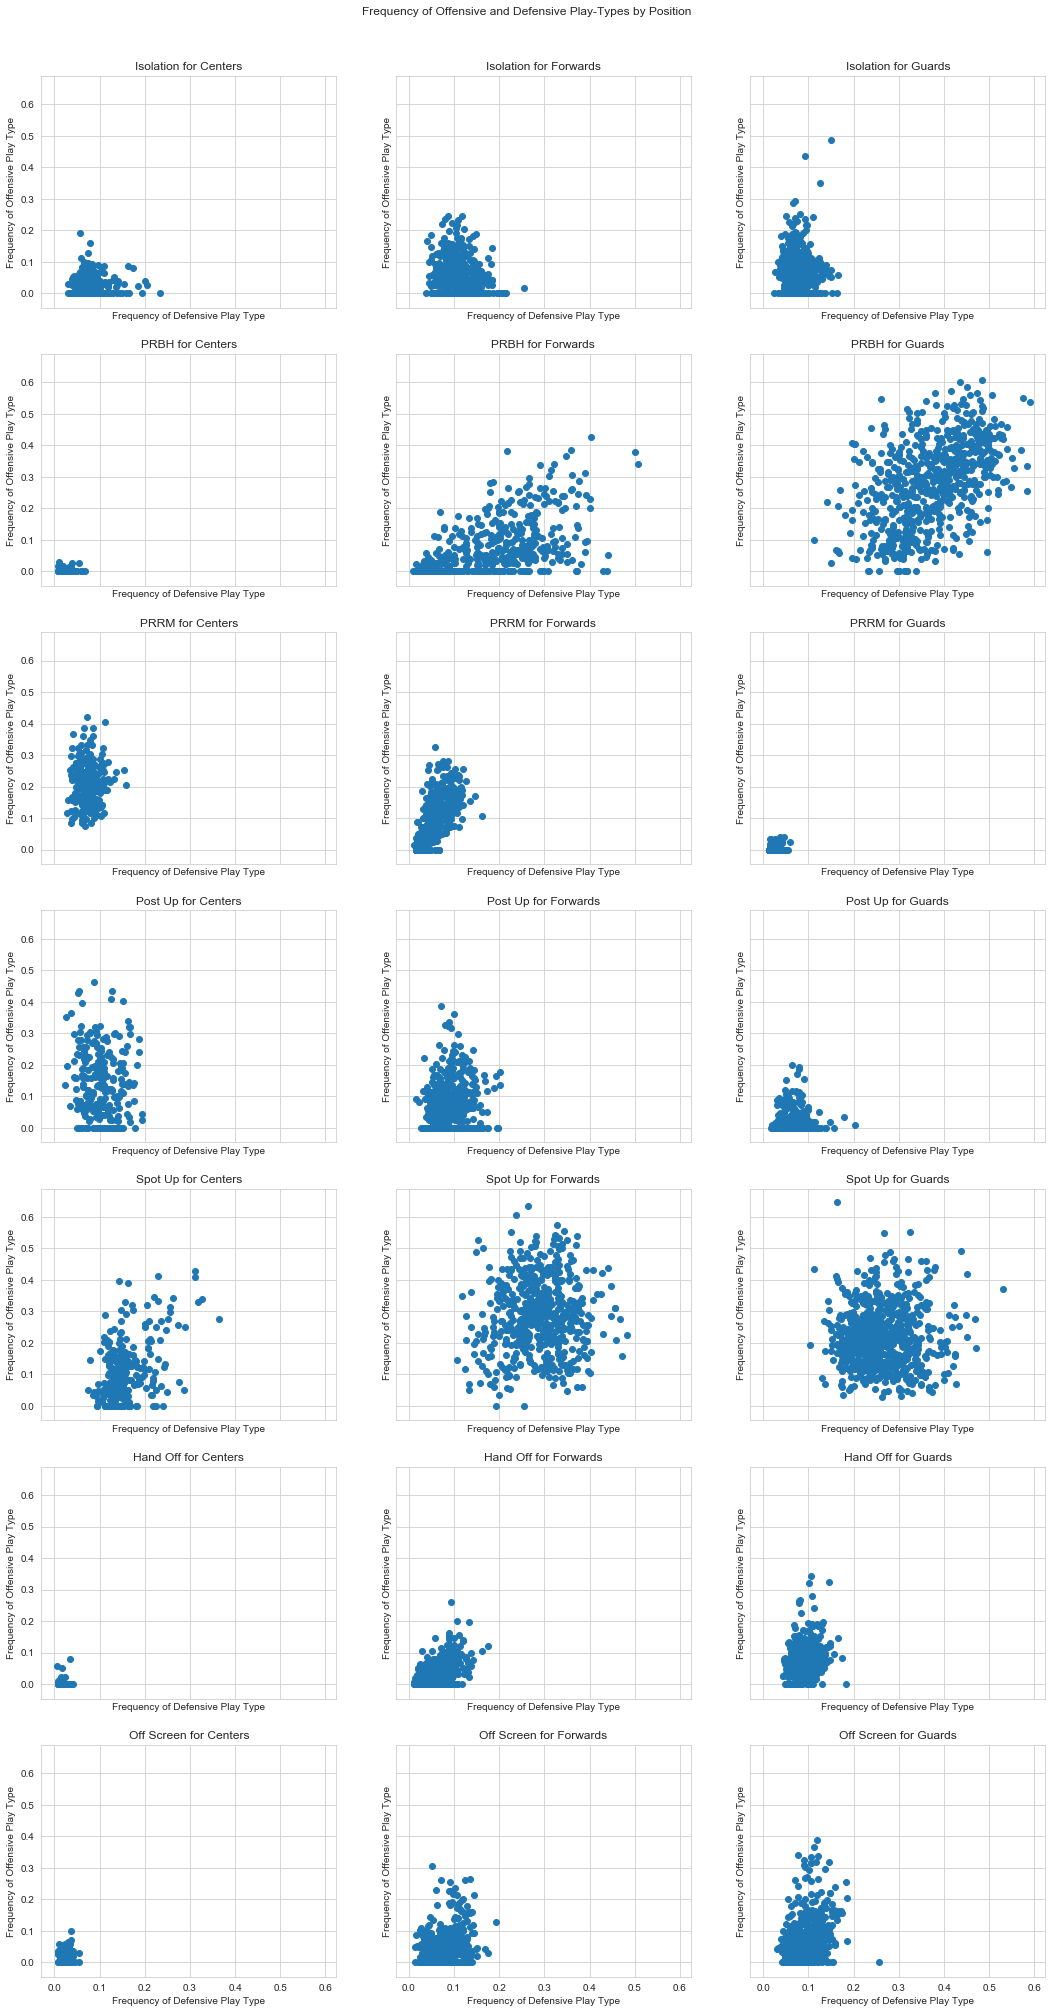

In [116]:
fig, ax = plt.subplots(7, 3, figsize=(18, 32), sharex=True, sharey=True)
#ax = ax.ravel()

plt.suptitle("Frequency of Offensive and Defensive Play-Types by Position")

fig.subplots_adjust(top=0.95)

for i,pt in enumerate(def_play_types):
    if pt != 'MISC':
        plt.axes(ax[i,0])
        plt.title(def_play_names[i]+' for Centers')
        plt.xlabel("Frequency of Defensive Play Type")
        plt.ylabel("Frequency of Offensive Play Type")
        plt.scatter(dfc[dfc["DEF_FREQ_"+pt]>0]['DEF_FREQ_'+pt], dfc[dfc["DEF_FREQ_"+pt]>0]['OFF_FREQ_'+pt], marker="o")
        
        plt.axes(ax[i,1])
        plt.title(def_play_names[i]+' for Forwards')
        plt.xlabel("Frequency of Defensive Play Type")
        plt.ylabel("Frequency of Offensive Play Type")
        plt.scatter(dff[dff["DEF_FREQ_"+pt]>0]['DEF_FREQ_'+pt], dff[dff["DEF_FREQ_"+pt]>0]['OFF_FREQ_'+pt], marker="o")
        
        plt.axes(ax[i,2])
        plt.title(def_play_names[i]+' for Guards')
        plt.xlabel("Frequency of Defensive Play Type")
        plt.ylabel("Frequency of Offensive Play Type")
        plt.scatter(dfg[dfg["DEF_FREQ_"+pt]>0]['DEF_FREQ_'+pt], dfg[dfg["DEF_FREQ_"+pt]>0]['OFF_FREQ_'+pt], marker="o")

        

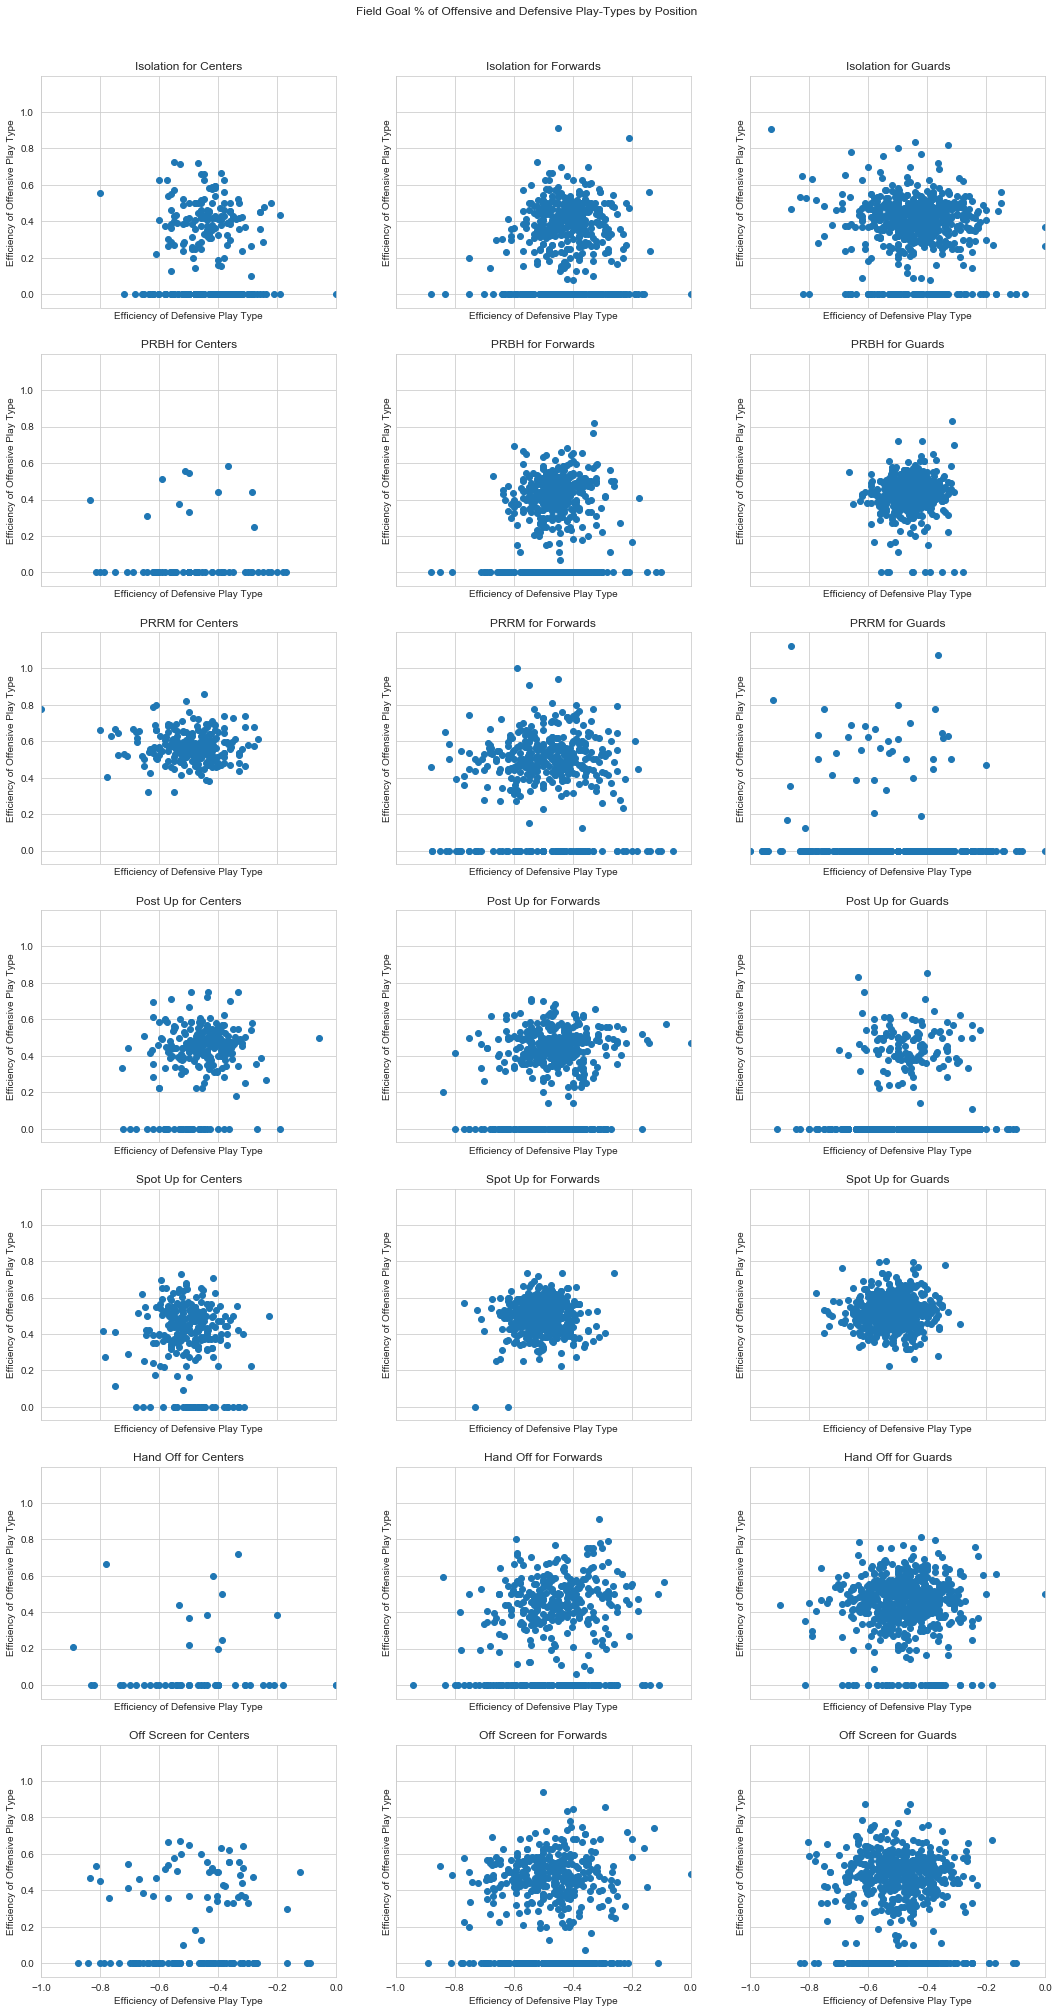

In [117]:
fig, ax = plt.subplots(7, 3, figsize=(18, 32), sharex=True, sharey=True)
#ax = ax.ravel()

plt.suptitle("Field Goal % of Offensive and Defensive Play-Types by Position")

fig.subplots_adjust(top=0.95)

for i,pt in enumerate(def_play_types):
    if pt != 'MISC':
        plt.axes(ax[i,0])
        plt.title(def_play_names[i]+' for Centers')
        plt.xlabel("Efficiency of Defensive Play Type")
        plt.ylabel("Efficiency of Offensive Play Type")
        plt.scatter(-dfc[dfc["DEF_FREQ_"+pt]>0]['DEF_EFGP_'+pt], dfc[dfc["DEF_FREQ_"+pt]>0]['OFF_EFGP_'+pt], marker="o")
        if i == 0:
            plt.xlim(-1,0)
        
        plt.axes(ax[i,1])
        plt.title(def_play_names[i]+' for Forwards')
        plt.xlabel("Efficiency of Defensive Play Type")
        plt.ylabel("Efficiency of Offensive Play Type")
        plt.scatter(-dff[dff["DEF_FREQ_"+pt]>0]['DEF_EFGP_'+pt], dff[dff["DEF_FREQ_"+pt]>0]['OFF_EFGP_'+pt], marker="o")
        
        plt.axes(ax[i,2])
        plt.title(def_play_names[i]+' for Guards')
        plt.xlabel("Efficiency of Defensive Play Type")
        plt.ylabel("Efficiency of Offensive Play Type")
        plt.scatter(-dfg[dfg["DEF_FREQ_"+pt]>0]['DEF_EFGP_'+pt], dfg[dfg["DEF_FREQ_"+pt]>0]['OFF_EFGP_'+pt], marker="o")        

        